In [74]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
import numpy as np
from sklearn import utils
tf.set_random_seed(777)

def preprocess(Data,max_norm=1,min_norm=0):
    #normalization
    Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm
    # for i in range(len(Data.columns)):
    #     Data[Data.columns[i]] = (Data[Data.columns[i]] - Data[Data.columns[i]].mean())/Data[Data.columns[i]].std()
    #     print('standardized')
    #standardization
    #for i in range(len(Data.columns)):
    #    if Data[Data.columns[i]].std()*3 > (Data[Data.columns[i]].max()-Data[Data.columns[i]].min()):
    #        Data[Data.columns[i]] = (Data[Data.columns[i]] - Data[Data.columns[i]].mean())/Data[Data.columns[i]].std()
    #        print('standardized %d'%i)
    #    else:
    #        Data = (Data - Data.min())/(Data.max() - Data.min())*(max_norm - min_norm) + min_norm
    return Data

Data = pd.read_csv(r'D:\Desktop\190305\csvfile\new\새 폴더 (3)\0d_mean_orig_channel.csv')

# del Data['Unnamed: 0']
# del Data['Nu_t_lsq_n']
del Data['PHI-Alpha_t_lsq_n']
# del Data['Re']
# del Data['Pr']
del Data['X']
# del Data['Y']
del Data['y_plus']
del Data['wedge_height']
del Data['1/Pr']
# del Data['local_volume']

# a = Data['local_volume']

del Data['local_volume']

# Data = pd.DataFrame()
# Data['dk_dx_i_abs'] = data['dk_dx_i_abs']
# Data['dT/dx'] = data['dT/dx']
# Data['dT/dy'] = data['dT/dy']
# # Data['Nu_t_lsq_n'] = data['Nu_t_lsq_n']
# Data['PHI-Alpha_t_lsq_n'] = data['PHI-Alpha_t_lsq_n']
# # Data['PHI-Pr_t_new'] = data['PHI-Pr_t_new']

denorm_min = Data['PHI-Pr_t_new'].min()
denorm_max = Data['PHI-Pr_t_new'].max()

X = Data[Data.columns[:-1]]
X_length = len(X.columns)
Y = Data[Data.columns[-1:]]


x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

# nu_t = x_test['Nu_t_lsq_n']
train_index = x_train['Y']
test_index = x_test['Y']

del x_train['Y']
del x_test['Y']

x_train = preprocess(x_train)
x_test = preprocess(x_test)
y_train = preprocess(y_train)
y_test = preprocess(y_test)

x_train = x_train.values.tolist()
x_test = x_test.values.tolist()
y_train = y_train.values.tolist()
y_test = y_test.values.tolist()

X = tf.placeholder(tf.float32, [None, X_length-1])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)

initializer = tf.keras.initializers.he_normal()

W1 = tf.Variable(initializer([X_length-1,32]))
L1 = tf.nn.relu(tf.matmul(X,W1))
L1 = tf.nn.dropout(L1,keep_prob)

W2 = tf.Variable(initializer([32,16]))
L2 = tf.nn.relu(tf.matmul(L1,W2))
L2 = tf.nn.dropout(L2,keep_prob)

W3 = tf.Variable(initializer([16,8]))
L3 = tf.nn.relu(tf.matmul(L2,W3))
L3 = tf.nn.dropout(L3,keep_prob)

W4 = tf.Variable(initializer([8,8]))
# L4 = tf.matmul(L3,W4)
L4 = tf.nn.relu(tf.matmul(L3,W4))
L4 = tf.nn.dropout(L4,keep_prob)

W5 = tf.Variable(initializer([8,1]))
L5 = tf.matmul(L4,W5)
# L5 = tf.nn.relu(tf.matmul(L4,W5))
# L5 = tf.nn.dropout(L5,keep_prob)

# W6 = tf.Variable(initializer([2,1]))
# L6 = tf.matmul(L5,W6)
# L6 = tf.nn.relu(tf.matmul(L5,W6))
# L6 = tf.nn.dropout(L6,keep_prob)


cost = tf.reduce_mean(tf.square(L5 - Y))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

num_over = 0
epochs = 10000
batch_size = 128
shuffle = True

for epoch_index in range(epochs):
    if shuffle:
        utils.shuffle(x_train, y_train)
    total_batch = int(np.ceil(len(x_train) / batch_size))
    for batch_index in range(total_batch):
        start = batch_index*batch_size
        end = start + batch_size
        x_train_batch = x_train[start:end]
        y_train_batch = y_train[start:end]
        sess.run(optimizer, feed_dict={X: x_train_batch, Y:y_train_batch,keep_prob:0.8})
    
    loss_value_train = sess.run(cost, feed_dict={X: x_train, Y: y_train, keep_prob:1})
    loss_value_test = sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob:1})
    print('epoch: {}/{}, train loss: {:.4f}, test loss: {:.4f}'.format(epoch_index+1,epochs,loss_value_train,loss_value_test))
# for step in range(100000):

#     if step == 0:
#         test_loss = sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1})

#     _, cost_val = sess.run([optimizer, cost], feed_dict={X: x_train, Y: y_train, keep_prob: 0.8})

#     if (step + 1) % 1000 == 0:
#         _, cost_val = sess.run([optimizer, cost], feed_dict={X: x_train, Y: y_train, keep_prob: 0.8})
#         print(step, cost_val)

#     if sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1}) >= test_loss:
#         num_over += 1
#         test_loss = sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1})

#     if num_over == 100:
#         print('over fitting occurs')
#         break


ValueError: Shapes must be equal rank, but are 2 and 0 for 'Adam_25/update_Variable_134/Assign' (op: 'Assign') with input shapes: [46,32], [].

In [56]:
for step in range(100000):

    if step == 0:
        test_loss = sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1})

    _, cost_val = sess.run([optimizer, cost], feed_dict={X: x_train, Y: y_train, keep_prob: 0.8})

    if (step + 1) % 1000 == 0:
        _, cost_val = sess.run([optimizer, cost], feed_dict={X: x_train, Y: y_train, keep_prob: 0.8})
        print(step, cost_val)

    if sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1}) >= test_loss:
        num_over += 1
        test_loss = sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1})

    if num_over == 100:
        print('over fitting occurs')
        break


999 0.0338901
1999 0.040395368
2999 0.03548329
3999 0.034672886
4999 0.03639661
5999 0.040274546
6999 0.038858406
7999 0.033804823
8999 0.036102936
9999 0.03896214
10999 0.03895588
11999 0.039905135
12999 0.037942313
13999 0.037106633
14999 0.038621593
15999 0.038814466
16999 0.037168983
17999 0.03964533
18999 0.037543982
19999 0.03540096
20999 0.040815048
21999 0.046116944
22999 0.0398622
23999 0.039888166
24999 0.03456142
25999 0.034887105
26999 0.035784762
27999 0.033332426
28999 0.036769677
29999 0.03207523
30999 0.04090147
31999 0.037782874
32999 0.037898347
33999 0.03950728
34999 0.0363543
35999 0.038829338
36999 0.042569373
37999 0.035659354
38999 0.042350963
39999 0.03897334
40999 0.036518436
41999 0.03596589
42999 0.03815463
43999 0.03510924
44999 0.041092303
45999 0.03677564
46999 0.036829315
47999 0.038843624
48999 0.040252667
49999 0.04118985
50999 0.03718954
51999 0.037115764
52999 0.042273533
53999 0.035863243
54999 0.035800982
55999 0.035947546
56999 0.03640422
57999 0.0

In [57]:
print(sess.run(cost, feed_dict={X: x_test, Y: y_test, keep_prob: 1}))

0.004628775


[0, 1, 0, 1]

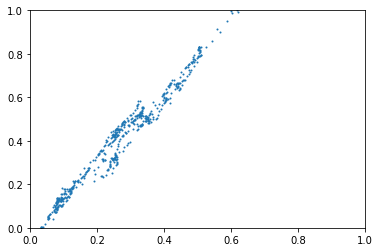

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sess.run(L5,feed_dict={X: x_test,keep_prob:1}),y_test,s=1)
plt.axis([0,1,0,1])